# Automated DFT band interpolation via Wannierization

In [3]:
from aiida import orm, load_profile
load_profile()

Profile<uuid='b35700dae723411ea16ebc82d58f16bc' name='mb'>

In [4]:
from aiida_wannier90_workflows.utils.workflows.builder.serializer import print_builder 
from aiida_wannier90_workflows.utils.kpoints import get_explicit_kpoints_from_mesh
from aiida_wannier90_workflows.utils.workflows.builder.setter import set_parallelization, set_num_bands, set_kpoints
from aiida_wannier90_workflows.utils.workflows.builder.submit import submit_and_add_group 
from aiida_wannier90_workflows.common.types import WannierProjectionType
from aiida_wannier90_workflows.workflows import Wannier90BandsWorkChain

## minimal inputs needed for protocols

In [5]:
codes = {
        "pw": "pw-6.8-p2w_ham@hydralogin",
        "pw2wannier90": "pw2wannier90-6.8-p2w_ham@hydralogin",
        "projwfc": "projwfc-7.1@hydralogin",
        "wannier90": "w90@hydralogin",
    }

In [ ]:
from aiida.orm import QueryBuilder
qb = QueryBuilder()
qb.append(orm.Group, filters={'label': 'hBN/bulk'}, tag='group')
qb.append(orm.StructureData, with_group='group')

loaded_structure_id = qb.all()[0][0].pk

In [6]:
options = {
    'pwcode_id': 'qe.pw@local_slurm', 
    'pseudo_family':"PseudoDojo/0.4/PBE/SR/standard/upf",
    'protocol':'fast',
    #'parent_id':274, #not necessary to set; if you want it, take ytheour previously nscf id (pk) to skip the DFT part.
    'structure_id':loaded_structure_id,
}

In [7]:
projections="analytic"

if projections=="analytic":
    wannier_projection_type=WannierProjectionType.ANALYTIC
else:
    WannierProjectionType.ATOMIC_PROJECTORS_QE 


In [8]:
builder = Wannier90BandsWorkChain.get_builder_from_protocol(
        codes=codes,
        structure=orm.load_node(options["structure_id"]),
        pseudo_family=options["pseudo_family"],
        protocol="fast",
        projection_type=wannier_projection_type,
    )

Summary of key input parameters:
  Formula: B2N2
  PseudoFamily: PseudoDojo/0.4/PBE/SR/standard/upf
  ElectronicType: METAL
  SpinType: NONE
  WannierProjectionType: ANALYTIC
  WannierDisentanglementType: SMV
  WannierFrozenType: ENERGY_FIXED
  num_bands: 20
  num_wann: 16
  mp_grid: [6, 6, 2]



In [9]:
parallelization = dict(
    max_wallclock_seconds=24 * 3600,
    # num_mpiprocs_per_machine=48,
    #npool=4,
    num_machines=1,
)

set_parallelization(
    builder,
    parallelization=parallelization,
    process_class=Wannier90BandsWorkChain,
)


#### START computational resources settings.

builder['nscf']['pw']['metadata'] = {'options': {'stash': {}, 'resources': {'num_machines':1, 'num_cores_per_mpiproc': 1, 'num_mpiprocs_per_machine': 16}, 'max_wallclock_seconds': 86400,
                                        'withmpi': True, 'queue_name': 's3par', 'prepend_text': 'export OMP_NUM_THREADS=1'}}

builder['scf']['pw']['metadata'] = {'options': {'stash': {}, 'resources': {'num_machines': 1, 'num_cores_per_mpiproc': 16, 'num_mpiprocs_per_machine': 1}, 'max_wallclock_seconds': 86400,
                                        'withmpi': True, 'queue_name': 's3par', 'prepend_text': 'export OMP_NUM_THREADS=16'}}

builder['pw2wannier90']['pw2wannier90']['metadata'] = {'options': {'stash': {}, 'resources': {'num_machines': 1, 'num_cores_per_mpiproc': 8, 'num_mpiprocs_per_machine':2}, 'max_wallclock_seconds': 86400,
                                        'withmpi': True, 'queue_name': 's3par', 'prepend_text': 'export OMP_NUM_THREADS=8'}}

builder['wannier90']['wannier90']['metadata'] = {'options': {'stash': {}, 'resources': {'num_machines': 1, 'num_cores_per_mpiproc':2, 'num_mpiprocs_per_machine': 8}, 'max_wallclock_seconds': 86400,
                                        'withmpi': True, 'queue_name': 's3par', 'prepend_text': 'export OMP_NUM_THREADS=2'}}

#### END computational resources settings.

In [51]:
# Use 4x4x4 kmesh
kpoints = get_explicit_kpoints_from_mesh(builder.structure, [4, 4, 4])
set_kpoints(builder, kpoints, process_class=Wannier90BandsWorkChain)

In [53]:
# START projections settings:
    
set_num_bands(
    builder=builder, 
    num_bands=32,                   # KS states used in the Wannierization
    #exclude_bands=range(1,5), 
    process_class=Wannier90BandsWorkChain)

params = builder.wannier90.wannier90.parameters.get_dict()

## START explicit atomic projections:
if projections=="analytic":

    del builder.projwfc
    builder.wannier90.auto_energy_windows = False
    builder.wannier90.shift_energy_windows = True
    params['num_wann'] = 16
    builder.wannier90.wannier90.projections = orm.List(list=['B:s', 'B:p', 'N:s', 'N:p'])
    params.pop('auto_projections', None) # Uncomment this if you want analytic atomic projections

    #
    # The following line can be also deleted.
    builder['pw2wannier90']['pw2wannier90']['parameters'] = orm.Dict(dict={'inputpp': {'atom_proj': False}})

## END explicit atomic projections:

# optional settings.
#params.pop('dis_proj_min', None)
#params.pop('dis_proj_max', None)
#params['num_wann'] = 16
#params['dis_froz_max'] = 2

params = orm.Dict(dict=params)
builder.wannier90.wannier90.parameters = params

# END projections settings.

In [55]:
print_builder(builder)

{'clean_workdir': False,
 'kpoints_force_gw': True,
 'nscf': {'kpoints': '64 kpts<None>',
          'kpoints_force_parity': False,
          'pw': {'code': 'pw-6.8-p2w_ham@hydralogin<2939>',
                 'metadata': {'options': {'max_wallclock_seconds': 86400,
                                          'prepend_text': 'export '
                                                          'OMP_NUM_THREADS=1',
                                          'queue_name': 's3par',
                                          'resources': {'num_cores_per_mpiproc': 1,
                                                        'num_machines': 1,
                                                        'num_mpiprocs_per_machine': 16},
                                          'withmpi': True}},
                 'parallelization': {'npool': 1},
                 'parameters': {'CONTROL': {'calculation': 'nscf',
                                            'etot_conv_thr': 0.0004,
                            

### Computational resources

In [56]:
from aiida.engine import submit

In [57]:
run = None

In [58]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

uuid: 2188c2dd-d0db-4078-912d-6b6100bdfb7a (pk: 16085) (aiida.workflows:wannier90_workflows.bands)


In [11]:
!verdi process report {run.pk}

2024-01-24 19:07:25 [7958 | REPORT]: [16085|Wannier90BandsWorkChain|run_seekpath]: launching seekpath: B2N2 -> B2N2
2024-01-24 19:07:26 [7959 | REPORT]: [16085|Wannier90BandsWorkChain|run_scf]: launching PwBaseWorkChain<16093> in scf mode
2024-01-24 19:07:27 [7960 | REPORT]:   [16093|PwBaseWorkChain|run_process]: launching PwCalculation<16096> iteration #1
2024-01-24 23:58:59 [7969 | REPORT]:   [16093|PwBaseWorkChain|results]: work chain completed after 1 iterations
2024-01-24 23:59:00 [7970 | REPORT]:   [16093|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned
2024-01-24 23:59:00 [7971 | REPORT]: [16085|Wannier90BandsWorkChain|run_nscf]: launching PwBaseWorkChain<16110> in nscf mode
2024-01-24 23:59:02 [7972 | REPORT]:   [16110|PwBaseWorkChain|run_process]: launching PwCalculation<16113> iteration #1
2024-01-25 00:01:18 [7982 | REPORT]:   [16110|PwBaseWorkChain|results]: work chain completed after 1 iterations
2024-01-25 00:01:19 [7983 | REPORT]:   [16110|PwBaseWorkCha

## Plotting band interpolation results.

In [13]:
import matplotlib.pyplot as plt

In [15]:
dftw90, b = orm.load_node(16085),8


w90_qe = dftw90.outputs.band_structure

In [18]:
l_x = []
l_names = []

for i in w90_qe.labels:
    l_x.append(i[0])
    if i[1] == 'GAMMA':
        l_names.append("$\Gamma$")
    else:
        l_names.append(i[1])

(0.0, 650.0)

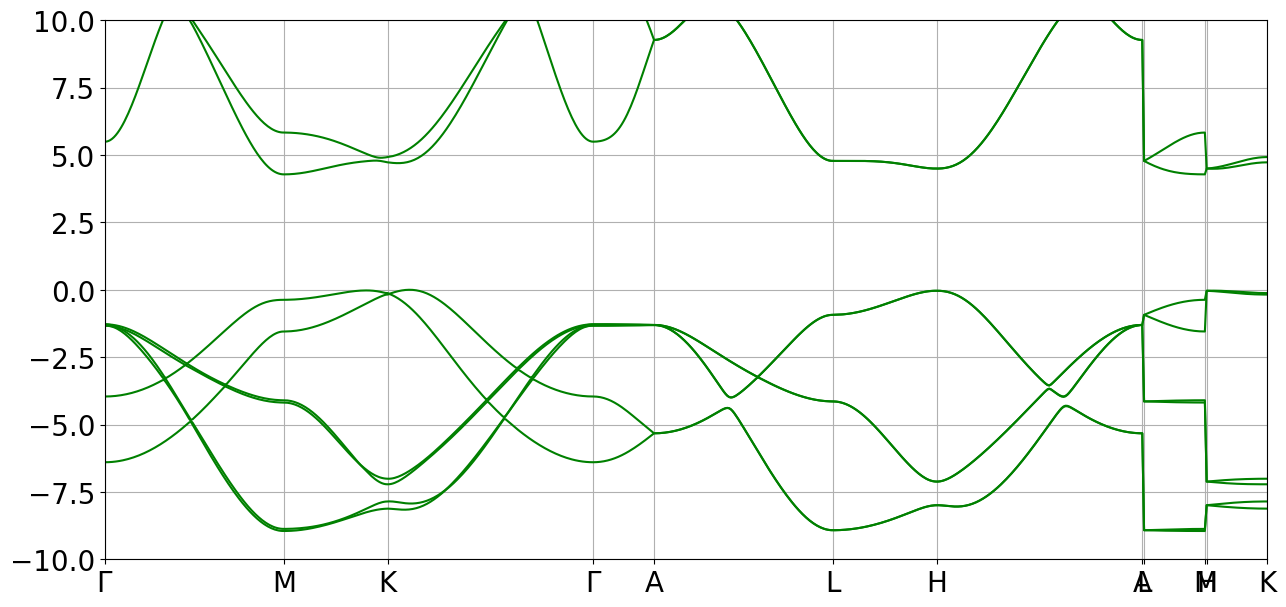

In [20]:
fig,ax=plt.subplots(figsize=[15,7])
plt.plot(w90_qe.get_bands()-max(w90_qe.get_bands()[:,b-1]),'-',color='green',label = 'DFT')
plt.ylim(-10,10)

plt.grid()
plt.xticks(l_x,l_names)
plt.tick_params(axis='both',labelsize=20)
plt.xlim(0,max(l_x))
#plt.ylim(-2,5)
#plt.legend()

#plt.savefig('plot_.pdf')